In [42]:
import cv2
import matplotlib.pyplot as plt
import deepdish as dd
import numpy as np
from util.reconstruction import Class_3D

sensor_id = "W00"
model_id = "RGB"
model_fn = f"models/LUT_{sensor_id}_{model_id}.pkl"
c3d = Class_3D(model_fn=model_fn, features_type=model_id)

def imshow(im, vmin=0, vmax=1):
    plt.imshow(im[:,:,::-1], vmax=vmax, vmin=vmin)
    plt.show()

frames = dd.io.load("data/fabric2.h5")

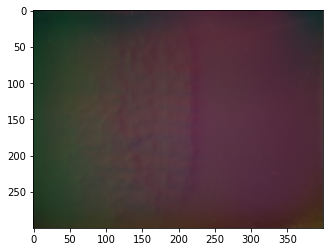

In [35]:
imshow(frames[200])

In [37]:
len(frames)

689

In [43]:
import imutils
from numpy import sin, cos
from scipy import ndimage

# depth => RGB image with Lambertian assumption
def render(depth, k=0.35):
    gy, gx = np.gradient(depth)

    rendered_img = np.zeros(frame.shape)
    theta_x = np.arctan(gx*5)
    theta_y = np.arctan(gy*5)

    rendered_img[:,:,1] = np.cos(np.pi / 2 - theta_x) * k * 1.2
    rendered_img[:,:,0] = np.cos(np.pi / 2 + theta_y) * k / 2
    rendered_img[:,:,2] = np.cos(np.pi / 2 - theta_y) * k * 1

    rendered_img[:,:,1] += 0.03
    return rendered_img

# blur of the boundaries
def blend(img, mask, rng=30):
    distance = ndimage.distance_transform_edt(1 - mask)
    distance_clip = 1 / (1 + np.exp(-(distance - rng) / 10)) 

    distance_clip = 1 - distance_clip
    distance_clip_RGB = np.dstack([distance_clip, distance_clip, distance_clip])

    img_blur = cv2.GaussianBlur(img, (185,185), 0)

    img_mix = distance_clip_RGB * img_blur + (1 - distance_clip_RGB) * img
    return img_mix

# transform the depth
def transform(depth, theta, dx, dy, depth_max=10):    
    rows, cols = depth.shape[:2]
    
    depth_img = np.dstack([depth / depth_max] * 3)


    M = cv2.getRotationMatrix2D((cols/2, rows/2), theta, 1)
    M[:, 2] += [dx, dy]

    shifted = cv2.warpAffine(depth_img, M, (cols, rows))

#     generate mask
    mask = np.ones(depth_img.shape)
    mask = cv2.warpAffine(mask, M, (cols, rows))

    mask = 1 - mask[:,:,0]
    
    return shifted, mask, M

# visualization
def draw_line(img, theta, x0, y0):
    theta = theta / 180. * np.pi
    img = img.copy()
    rows, cols = img.shape[:2]
    
    center = np.array([x0 * cols, y0 * rows])
    
    d = 1100
    
    start_point = center + (d * sin(theta), d * cos(theta))
    end_point = center - (d * sin(theta), d * cos(theta))
    
    start_point = tuple(start_point.astype(np.int))
    end_point = tuple(end_point.astype(np.int))

    color = (0, 0, 1)
    thickness = 4
    
    img = cv2.line(img, start_point, end_point, color, thickness) 
    return img


In [39]:

frame0 = frames[0]
# frame = frames[280]
# frame = frames[460]

frame = frames[200]
# frame = frames[375]
# frame = frames[455]



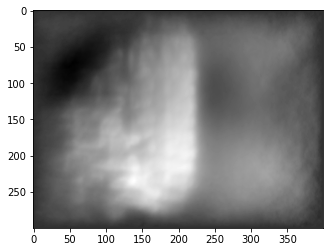

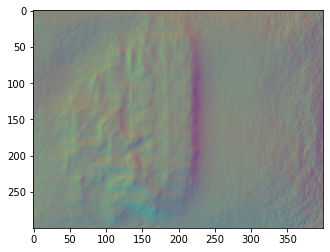

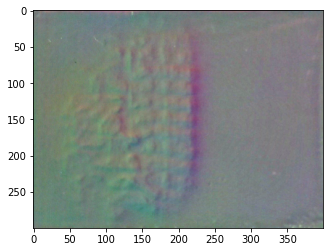

In [41]:

plt.imshow(depth, cmap="gray")
plt.show()

rendered_img = render(depth) + 0.5
imshow(rendered_img)


frame0_blur = cv2.GaussianBlur(frames[0], (45, 45), 0)
diff = (frames[200] * 1.0 - frame0_blur) / 255. * 4.0 + 0.5
imshow(diff)

In [44]:

diff = (frame * 1.0 - frame0) / 255. + 0.5
diff_img = (diff - 0.5) * 4 + 0.5

# Get depth
depth, gx, gy = c3d.infer(diff * 255.0, display=False)

# Get label
theta0 = 0
x0, y0 = (225, 145)

# Transform
theta = 30
dx, dy = 20, 0
depth_max = 10

rows, cols = frame.shape[:2]

X = []
Y = []

x, y = np.arange(rows), np.arange(cols)
yy, xx = np.meshgrid(y, x)

# for theta in range(-120, 61, 30):
# for theta in [0]:
for i in range(10):
# for i in range(1):
    theta = np.random.random() * 180 - 90
    dx, dy = np.random.random() - 0.5, np.random.random() - 0.5
    dx, dy = dx * cols * 0.5, dy * rows * 0.5
    
    
#     depth_augmented = (depth)
    depth_augmented = (depth - depth.max() * np.random.random() * 0.8)
    depth_augmented = np.maximum(depth_augmented, 0)
    
#     mu = np.array([np.random.random() * cols, np.random.random() * rows])
#     sigma = np.random.random() * 60
#     depth_bump = np.exp(-( ((xx-mu[0])**2 + (yy-mu[1])**2) / ( 2.0 * sigma**2 ) ) )
    
#     theta = 0
#     dx, dy = 0, 0
#     depth_augmented = depth
    
    shifted, mask, M = transform(depth_augmented, theta, dx, dy, depth_max=depth_max)

    img_mix = blend(shifted, mask)
    rendered_img = render(img_mix[:,:,0] * depth_max)

    noise = np.random.normal(0, 0.03, size=rendered_img.shape)
    rendered_img += noise

#     draw line
    theta1 = theta0 + theta
        
    while theta1 > 180:
        theta1 -= 360
    while theta1 < -180:
        theta1 += 360
    
    X0 = np.array([[x0], [y0], [1.]])
    X1 = M.dot(X0)
    x1, y1 = X1[0, 0] / cols, X1[1, 0] / rows
    
#     plt.figure()
    rendered_img_line = draw_line(rendered_img + 0.5, theta1, x1, y1)
    
    rendered_small = cv2.resize(rendered_img + 0.5, (120, 90))
#     imshow(rendered_small)
    
    X.append(rendered_small)
    Y.append([x1, y1, theta1])
    
    if i % 100 == 0:
        print(i)
#     imshow(rendered_img + 0.5)

#     imshow(rendered_img_line)

2.8847933
0


In [45]:
data = {"X": np.array(X), "Y": np.array(Y)}
dd.io.save("dataset/fabric_pose.h5", data)

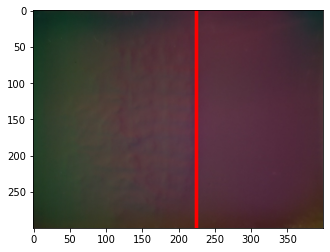

In [40]:
theta0 = 0
x0, y0 = (225, 145)

x = cv2.resize(frames[200], (400, 300)) / 255.
# theta: in degrees
# x0: 0-1 (=>(0, cols))
# y0: 0-1 (=>(0, rows))
rendered_img_line = draw_line(x , theta0, x0 / cols, y0 / rows)
imshow(rendered_img_line)


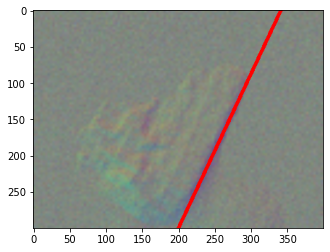

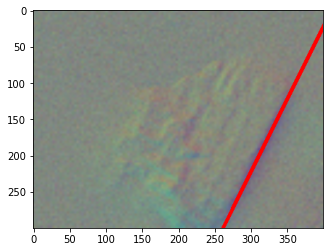

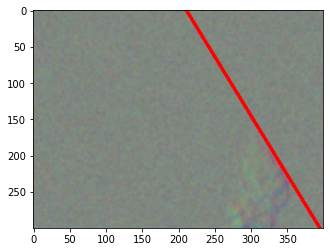

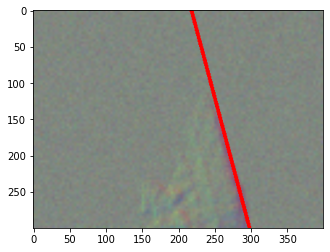

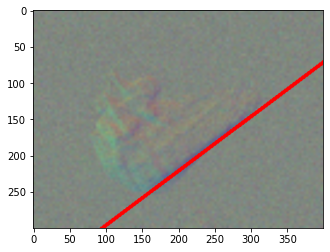

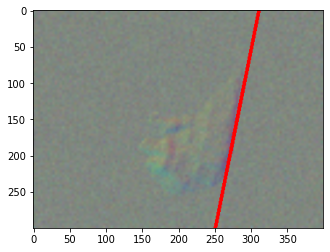

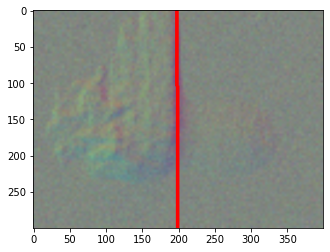

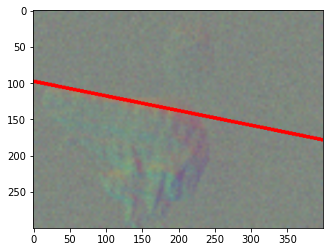

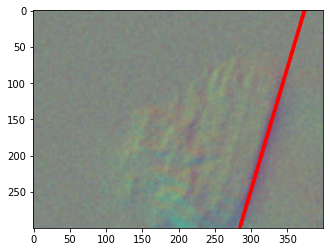

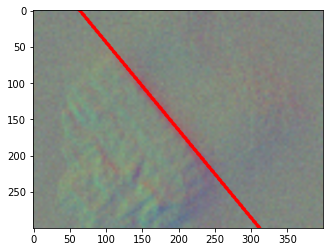

In [46]:

for x, y in zip(X, Y):
    x = cv2.resize(x, (400, 300))
    rendered_img_line = draw_line(x, y[2], y[0], y[1])
    imshow(rendered_img_line)
    